In [1]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load ground truth

In [2]:
images = skimage.io.imread_collection("p_06Eggert_TMRact4c820uMpra125uMpracd2000ef4gh610x_D12_s4_w1/*.png")

In [3]:
image = images.concatenate()

In [4]:
image.shape

(55, 1040, 1392)

# Transform to label matrix

In [5]:
image = skimage.img_as_bool(image)

labels = np.zeros((1040, 1392), np.uint16)

for index in range(0, 55):
    labels[image[index] > 0] = index

/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from uint8 to bool
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


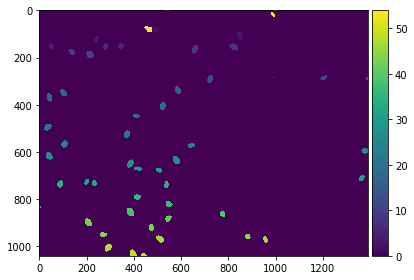

In [6]:
skimage.io.imshow(labels)

# Simulate prediction

In [7]:
# Shift n pixels in each direction

spx = 2

y_true = labels

y_pred = labels[spx:, spx:]

y_pred = np.pad(y_pred, ((0, spx), (0, spx)), mode="constant")

In [8]:
# Remove one object

y_pred[y_pred == 20] = 0

In [9]:
# Merge two objects

y_pred[710:742,185:243] = np.max(y_pred[710:742,185:243])

In [10]:
# Oversegment one object

y_pred[610:650,580:600] = (np.max(y_pred)+1)*(y_pred[610:650,580:600] > 0)

In [11]:
# Relabel objects

y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred)

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


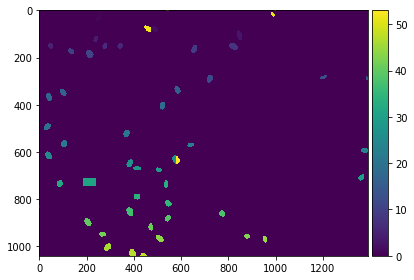

In [12]:
# Show simulated predictions

skimage.io.imshow(y_pred)

In [13]:
true_objects = len(np.unique(y_true))

pred_objects = len(np.unique(y_pred))

print("Number of true objects:", true_objects)

print("Number of predicted objects:", pred_objects)

Number of true objects: 55
Number of predicted objects: 54


# Compute intersection

In [14]:
h = np.histogram2d(y_true.flatten(), y_pred.flatten(), bins=(true_objects,pred_objects))

intersection = h[0]

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


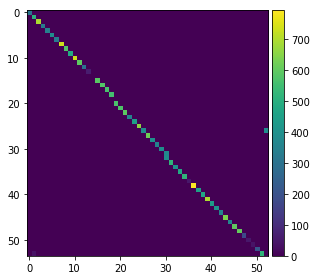

In [15]:
skimage.io.imshow(intersection[1:,1:])

# Area of objects

In [16]:
area_true = np.histogram(y_true, bins=true_objects)[0]

area_pred = np.histogram(y_pred, bins=pred_objects)[0]

# Calculate union

In [17]:
area_true = np.expand_dims(area_true, -1)

area_pred = np.expand_dims(area_pred, 0)

union = area_true + area_pred - intersection

In [18]:
intersection.shape, union.shape

((55, 54), (55, 54))

# Intersection over Union

In [19]:
# Exclude background from the analysis

intersection = intersection[1:,1:]

union = union[1:,1:]

In [20]:
union[union == 0] = 1e-9

IOU = intersection/union

In [21]:
np.min(IOU), np.max(IOU)

(0.0, 0.82485207100591718)

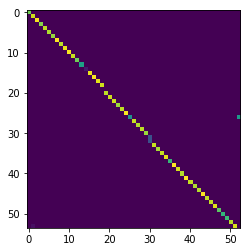

In [22]:
plt.imshow(IOU)

# Average Precision

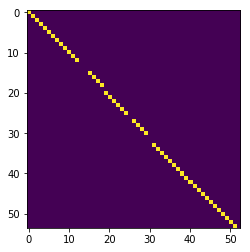

In [23]:
plt.imshow(IOU > 0.5)

In [24]:
def precision_at(threshold, IOU):
    
    matches = IOU > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    return TP, FP, FN

In [25]:
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    TP, FP, FN = precision_at(t, IOU)
    p = TP / (TP + FP + FN)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, TP, FP, FN, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	48	5	6	0.814
0.550	47	6	7	0.783
0.600	45	8	9	0.726
0.650	42	11	12	0.646
0.700	40	13	14	0.597
0.750	24	29	30	0.289
0.800	8	45	46	0.081
0.850	0	53	54	0.000
0.900	0	53	54	0.000
0.950	0	53	54	0.000
AP	-	-	-	0.394
